In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import re

# Load the data from the JSON file
with open('LIAR-Evaluated.json', 'r') as f:
    data = json.load(f)

# Convert the data into a pandas DataFrame
df = pd.DataFrame(data)
df['classification1'] = df['classification1'].str.lower()
df['classification2'] = df['classification2'].str.lower()

def test_data(df):
    # Check that 'classification1' and 'classification2' are either 'true' or 'false'
    if not df['classification1'].isin(['true', 'false']).all():
        invalid_vals1 = df.loc[~df['classification1'].isin(['true', 'false']), 'classification1']
        print(f"'classification1' has invalid values: {invalid_vals1}")
    if not df['classification2'].isin(['true', 'false']).all():
        invalid_vals2 = df.loc[~df['classification2'].isin(['true', 'false']), 'classification2']
        print(f"'classification2' has invalid values: {invalid_vals2}")

    # Check that 'true certainty1', 'true certainty2', 'prediction_gpt', 'prediction_davinci', and 'truth' are strings representing integers between 0 and 100
    for column in ['true certainty1', 'true certainty2', 'prediction_gpt', 'prediction_davinci', 'truth']:
        assert df[column].str.isdigit().all(), f"'{column}' has non-digit values"
        assert df[column].astype(int).between(0, 100).all(), f"'{column}' has values outside the range 0-100"

test_data(df)

'classification1' has invalid values: 17    false.75
Name: classification1, dtype: object
'classification2' has invalid values: 11    false.70
21    false.25
Name: classification2, dtype: object


AssertionError: 'true certainty1' has non-digit values

C:\Users\12406\AppData\Local\Temp\ipykernel_20528\185780166.py:47: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax1 = sns.barplot(data=df_melted, x='classification status', y='correct', hue='model', ci=None)


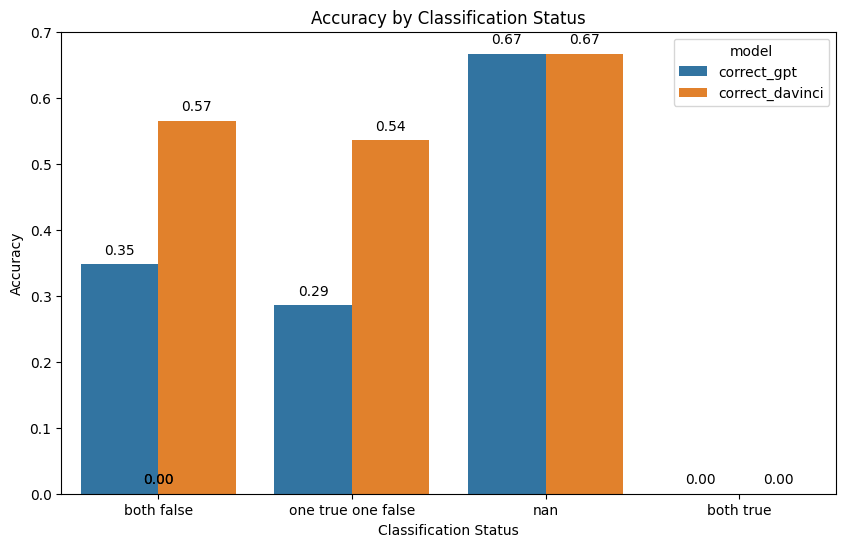

C:\Users\12406\AppData\Local\Temp\ipykernel_20528\185780166.py:64: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax2 = sns.barplot(data=df_melted, x='certainty difference bin', y='correct', hue='model', ci=None)


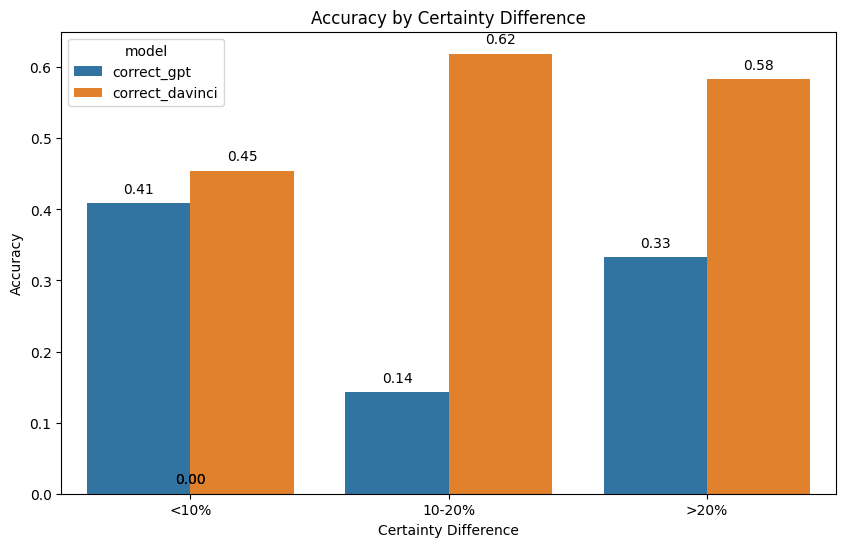

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import numpy as np

# Load the data from the JSON file
with open('LIAR-Evaluated.json', 'r') as f:
    data = json.load(f)

# Convert the data into a pandas DataFrame
df = pd.DataFrame(data)

# Convert 'true certainty1' and 'true certainty2' to numeric values
df['true certainty1'] = pd.to_numeric(df['true certainty1'], errors='coerce')
df['true certainty2'] = pd.to_numeric(df['true certainty2'], errors='coerce')

# Calculate the difference in true certainties
df['certainty difference'] = abs(df['true certainty1'] - df['true certainty2'])

# Define bins for the certainty difference
bins = [0, 10, 20, df['certainty difference'].max()]
labels = ['<10%', '10-20%', '>20%']
df['certainty difference bin'] = pd.cut(df['certainty difference'], bins=bins, labels=labels)

# Define classification status
conditions = [
    (df['classification1'] == 'false') & (df['classification2'] == 'false'),
    (df['classification1'] == 'true') & (df['classification2'] == 'true'),
    ((df['classification1'] == 'true') & (df['classification2'] == 'false')) | ((df['classification1'] == 'false') & (df['classification2'] == 'true'))
]
choices = ['both false', 'both true', 'one true one false']
df['classification status'] = np.select(conditions, choices, default=np.nan)

# Calculate accuracy
df['correct_gpt'] = df['prediction_gpt'] == df['truth']
df['correct_davinci'] = df['prediction_davinci'] == df['truth']

# Melt the DataFrame to make it suitable for a dodged bar plot
df_melted = df.melt(id_vars=['classification status', 'certainty difference bin'], 
                    value_vars=['correct_gpt', 'correct_davinci'], 
                    var_name='model', 
                    value_name='correct')

# Plot accuracy by classification status
plt.figure(figsize=(10, 6))
ax1 = sns.barplot(data=df_melted, x='classification status', y='correct', hue='model', ci=None)
plt.title('Accuracy by Classification Status')
plt.xlabel('Classification Status')
plt.ylabel('Accuracy')

# Add percentage on top of each bar
for p in ax1.patches:
    ax1.annotate(format(p.get_height(), '.2f'), 
                 (p.get_x() + p.get_width() / 2., p.get_height()), 
                 ha = 'center', va = 'center', 
                 xytext = (0, 10), 
                 textcoords = 'offset points')

plt.show()

# Plot accuracy by certainty difference
plt.figure(figsize=(10, 6))
ax2 = sns.barplot(data=df_melted, x='certainty difference bin', y='correct', hue='model', ci=None)
plt.title('Accuracy by Certainty Difference')
plt.xlabel('Certainty Difference')
plt.ylabel('Accuracy')

# Add percentage on top of each bar
for p in ax2.patches:
    ax2.annotate(format(p.get_height(), '.2f'), 
                 (p.get_x() + p.get_width() / 2., p.get_height()), 
                 ha = 'center', va = 'center', 
                 xytext = (0, 10), 
                 textcoords = 'offset points')

plt.show()

In [ ]:
# Count the number of entries for each classification status
classification_counts = df['classification status'].value_counts()

print(classification_counts)

classification status
nan                   50
both false            37
one true one false    12
Name: count, dtype: int64
